# Entrainment: fixed <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we fix the problems we were experiencing with entrainment calculations.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Zero-entrainment-case:-comparison-with-expected-values" data-toc-modified-id="Zero-entrainment-case:-comparison-with-expected-values-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Zero-entrainment case: comparison with expected values</a></span><ul class="toc-item"><li><span><a href="#Dry-descent-only" data-toc-modified-id="Dry-descent-only-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dry descent only</a></span></li><li><span><a href="#Moist-descent" data-toc-modified-id="Moist-descent-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Moist descent</a></span></li></ul></li><li><span><a href="#Dry-descent-testing" data-toc-modified-id="Dry-descent-testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dry descent testing</a></span><ul class="toc-item"><li><span><a href="#Dry-descent-vs.-entrainment-rate" data-toc-modified-id="Dry-descent-vs.-entrainment-rate-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dry descent vs. entrainment rate</a></span></li></ul></li><li><span><a href="#Moist-descent-testing" data-toc-modified-id="Moist-descent-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Moist descent testing</a></span><ul class="toc-item"><li><span><a href="#Moist-descent-vs.-entrainment-rate" data-toc-modified-id="Moist-descent-vs.-entrainment-rate-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Moist descent vs. entrainment rate</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Next steps</a></span></li></ul></div>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import metpy.calc as mpcalc
from metpy.units import units
from metpy.units import concatenate

from scipy.interpolate import interp1d

from os import mkdir
from os.path import exists
import sys

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, wetbulb, theta_e, descend
from thermo import saturation_specific_humidity, temperature_change

In [2]:
file = '../../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'height', 'temperature', 'dewpoint'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
height = sounding[:,1]*units.meter
temperature = sounding[:,2]*units.celsius
dewpoint = sounding[:,3]*units.celsius
sydney = Environment(
    pressure, height, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z', name='Sydney')

## Setup

We know how to calculate the temperature, specific humidity and liquid water content for entraining parcels, but the calculation is only valid for small downward displacements.

The previous method was:
1. Descend a small distance and divide the changes in the $T$, $q$ and $l$ values by the distance descended to obtain approximate derivatives w.r.t. height.
2. Use an ODE solver (Runge-Kutta method) to integrate these to work out $T$, $q$ and $l$ for larger downward displacements.

It is likely that the complicated multi-step approach of Runge-Kutta was causing problems. We instead take a much simpler approach:
1. Start at the initial height and find $T$, $q$ and $l$ after descending a small distance.
2. Repeat, taking small downward steps until the target height is reached.

In [58]:
# these functions are unchanged

def mix(parcel, environment, rate, dz):
    return parcel + rate * (environment - parcel) * dz

def equilibrate(
        pressure, t_parcel, q_parcel, l_parcel, t_env, q_env, l_env, rate, dz):
    """
    Finds parcel properties after entrainment and phase equilibration.
    
    Args:
        pressure: Pressure during the change (constant).
        t_parcel: Initial temperature of the parcel.
        q_parcel: Initial specific humidity of the parcel.
        l_parcel: Initial ratio of liquid mass to parcel mass.
        t_env: Temperature of the environment.
        q_env: Specific humidity of the environment.
        l_env: Liquid ratio of the environment.
        rate: Entrainment rate.
        dz: Distance descended.
        
    Returns:
        A tuple containing the final parcel temperature, specific
            humidity and liquid ratio.
    """
    
    # mixing without phase change
    t_mixed = mix(t_parcel, t_env, rate, dz)
    q_mixed = mix(q_parcel, q_env, rate, dz)
    l_mixed = mix(l_parcel, l_env, rate, dz)
    q_mixed_saturated = saturation_specific_humidity(pressure, t_mixed)
    
    if q_mixed > q_mixed_saturated:
        # we need to condense water vapour
        ept = theta_e(pressure, t_mixed, q_mixed)
        t_final = wetbulb(pressure, ept, improve=True)
        q_final = saturation_specific_humidity(pressure, t_final)
        l_final = l_mixed + q_mixed - q_final
        return (t_final, q_final, l_final)
    elif q_mixed < q_mixed_saturated and l_mixed > 0:
        # we need to evaporate liquid water.
        # if all liquid evaporates:
        t_all_evap = t_mixed + temperature_change(l_mixed)
        q_all_evap_saturated = saturation_specific_humidity(
            pressure, t_all_evap)
        
        if q_mixed + l_mixed <= q_all_evap_saturated:
            return (t_all_evap, q_mixed + l_mixed, 0*units.dimensionless)
        else:
            ept = theta_e(pressure, t_mixed, q_mixed)
            t_final = wetbulb(pressure, ept, improve=True)
            q_final = saturation_specific_humidity(pressure, t_final)
            l_final = l_mixed + q_mixed - q_final
            return (t_final, q_final, l_final)
    elif q_mixed < q_mixed_saturated and l_mixed <= 0:
        # already in equilibrium, no action needed
        return (t_mixed, q_mixed, 0*units.dimensionless)
    else:
        # parcel is perfectly saturated, no action needed
        return (t_mixed, q_mixed, l_mixed)

In [59]:
# this is new
def entrain_discrete(height, state, rate, dz):
    """
    Finds parcel properties after descent/entrainment.
    
    Only valid for small steps.
    
    Args:
        height: Initial height.
        state: 3-tuple of initial temperature, specific humidity, liquid ratio.
        rate: Entrainment rate.
        dz: Size of *downward* step, i.e. initial minus final height.
        
    Returns:
        3-tuple of final temperature, specific humidity and liquid ratio.
    """
    
    height = height
    t_parcel = state[0]
    q_parcel = state[1]
    l_parcel = state[2]
    p_initial = sydney.pressure(height)
    p_final = sydney.pressure(height - dz)
    
    # steps 1 and 2: mixing and phase equilibration
    t_eq, q_eq, l_eq = equilibrate(
        p_initial, t_parcel, q_parcel, l_parcel, 
        sydney.temperature(height), sydney.specific_humidity(height),
        sydney.liquid_ratio(height), rate, dz)
    
    # step 3: dry or moist adiabatic descent
    t_final, q_final, l_final = descend(
        p_final, t_eq, q_eq, l_eq, p_initial, improve=3)
    
    return (t_final, q_final, l_final)

In [60]:
# this is also new
def entrainment_profile(
        height, t_initial, q_initial, l_initial, rate, dz=50*units.meter,
        reference_height=None):
    """
    Calculates parcel properties for descent with entrainment.
    
    Valid for arbitrary steps.
    
    Args:
        height: Array of heights of interest.
        t_initial: Initial parcel temperature.
        q_initial: Initial parcel specific humidity.
        l_initial: Initial parcel liquid ratio.
        rate: Entrainment rate.
        dz: Size of *downward* step for computing finite differences.
        
    Returns:
        3-tuple containing the temperature, specific humidity and
            liquid ratio arrays for the given height array.
    """
    
    height = np.atleast_1d(height).m_as(units.meter)
    dz = dz.m_as(units.meter)
    if reference_height is not None:
        reference_height = reference_height.m_as(units.meter)
    
    # create height array with correct spacing
    if reference_height is None or reference_height == height[0]:
        all_heights = np.arange(height[0], height[-1], -dz)
        all_heights = np.append(all_heights, height[-1])*units.meter
    else:
        all_heights = np.arange(reference_height, height[-1], -dz)
        all_heights = np.append(all_heights, height[-1])*units.meter
    
    # calculate t, q and l one downward step at a time
    sol_states = [(t_initial, q_initial, l_initial)]
    for i in range(all_heights.size - 1):
        next_state = entrain_discrete(
            all_heights[i], sol_states[i], rate,
            all_heights[i] - all_heights[i+1])
        sol_states.append(next_state)
        
    t_sol = concatenate([state[0] for state in sol_states]).m_as(units.celsius)
    q_sol = concatenate([state[1] for state in sol_states]).m
    l_sol = concatenate([state[2] for state in sol_states]).m
    
    # find the values of t, q and l at the originally specified heights
    t_interp = interp1d(all_heights.m, t_sol)
    t_out = t_interp(height)*units.celsius
    q_interp = interp1d(all_heights.m, q_sol)
    q_out = q_interp(height)*units.dimensionless
    l_interp = interp1d(all_heights.m, l_sol)
    l_out = l_interp(height)*units.dimensionless
    
    # return scalars if only one height was given
    if height.size == 1:
        t_out = t_out.item()
        q_out = q_out.item()
        l_out = l_out.item()
    
    return t_out, q_out, l_out

## Zero-entrainment case: comparison with expected values

As a check, we set the entrainment rate to zero and compare the results of the entrainment calculation to what we would expect for a regular descending parcel.

### Dry descent only

In [7]:
height = np.arange(5000, -1, -100)*units.meter
pressure = sydney.pressure(height)
t_initial = -15*units.celsius
q_initial = saturation_specific_humidity(pressure[0], t_initial)

In [8]:
# expected values
result = [
    descend(p, t_initial, q_initial, 0, pressure[0], improve=2)
    for p in pressure]
t_true = concatenate([x[0] for x in result])
q_true = concatenate([x[1] for x in result])
l_true = concatenate([x[2] for x in result])

In [9]:
# entrainment values
t_entr1, q_entr1, l_entr1 = entrainment_profile(
    height, t_initial, q_initial, 0, 0/units.km, dz=1*units.meter)
t_entr10, q_entr10, l_entr10 = entrainment_profile(
    height, t_initial, q_initial, 0, 0/units.km, dz=10*units.meter)
t_entr50, q_entr50, l_entr50 = entrainment_profile(
    height, t_initial, q_initial, 0, 0/units.km, dz=50*units.meter)

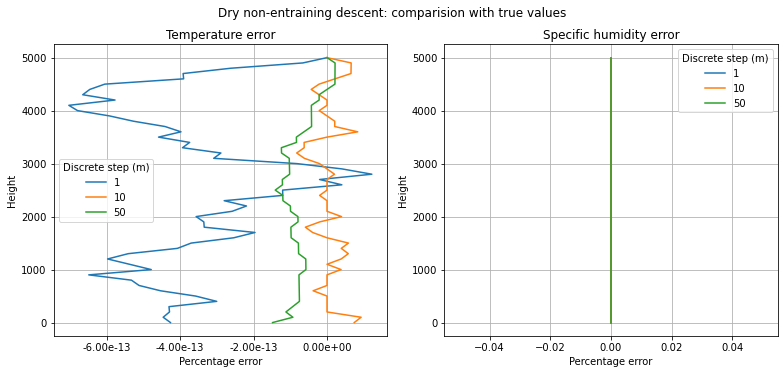

In [17]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
ax.plot((t_entr1 - t_true)/t_true*100, height, label='1')
ax.plot((t_entr10 - t_true)/t_true*100, height, label='10')
ax.plot((t_entr50 - t_true)/t_true*100, height, label='50')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
ax.grid()
lgd = ax.legend()
lgd.set_title('Discrete step (m)')
ax = fig.add_subplot(122)
ax.plot((q_entr1 - q_true)/q_true*100, height, label='1')
ax.plot((q_entr10 - q_true)/q_true*100, height, label='10')
ax.plot((q_entr50 - q_true)/q_true*100, height, label='50')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')
ax.grid()
lgd = ax.legend()
lgd.set_title('Discrete step (m)')
fig.tight_layout()
fig.suptitle('Dry non-entraining descent: comparision with true values',
             y=1.03)
plt.show()

### Moist descent

In [18]:
# expected values
result = [
    descend(p, t_initial, q_initial, 5e-3, pressure[0], improve=2)
    for p in pressure]
t_true = concatenate([x[0] for x in result])
q_true = concatenate([x[1] for x in result])
l_true = concatenate([x[2] for x in result])

In [19]:
# simple entrainment values
t_entr1, q_entr1, l_entr1 = entrainment_profile(
    height, t_initial, q_initial, 5e-3, 0/units.km, dz=1*units.meter)
t_entr10, q_entr10, l_entr10 = entrainment_profile(
    height, t_initial, q_initial, 5e-3, 0/units.km, dz=10*units.meter)
t_entr50, q_entr50, l_entr50 = entrainment_profile(
    height, t_initial, q_initial, 5e-3, 0/units.km, dz=50*units.meter)

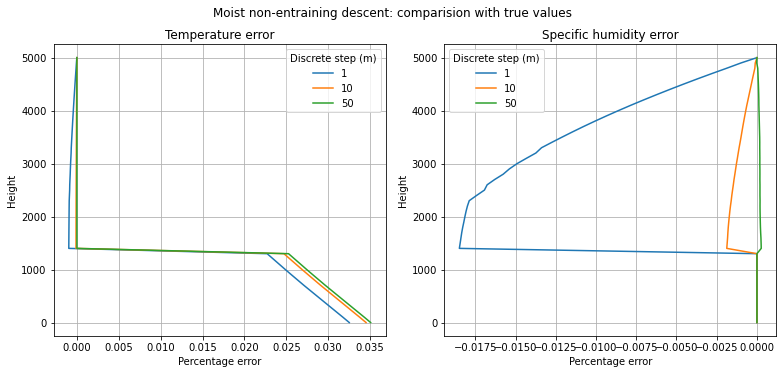

In [20]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
ax.plot((t_entr1 - t_true)/t_true*100, height, label='1')
ax.plot((t_entr10 - t_true)/t_true*100, height, label='10')
ax.plot((t_entr50 - t_true)/t_true*100, height, label='50')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')
ax.grid()
lgd = ax.legend()
lgd.set_title('Discrete step (m)')
ax = fig.add_subplot(122)
ax.plot((q_entr1 - q_true)/q_true*100, height, label='1')
ax.plot((q_entr10 - q_true)/q_true*100, height, label='10')
ax.plot((q_entr50 - q_true)/q_true*100, height, label='50')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')
ax.grid()
lgd = ax.legend()
lgd.set_title('Discrete step (m)')
fig.tight_layout()
fig.suptitle('Moist non-entraining descent: comparision with true values',
             y=1.03)
plt.show()

## Dry descent testing

### Dry descent vs. entrainment rate

We now test the functions on a parcel that is initially drier than the environment and contains no liquid water.

In [21]:
height = np.arange(5000, 2999, -100)*units.meter

In [24]:
%%time
t1, q1, l1 = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0, 0/units.km)
t2, q2, l2 = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0, 0.5/units.km)
t3, q3, l3 = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0, 1/units.km)

CPU times: user 834 ms, sys: 12 ms, total: 846 ms
Wall time: 876 ms


The above calculation is about twice as fast as the integration method!

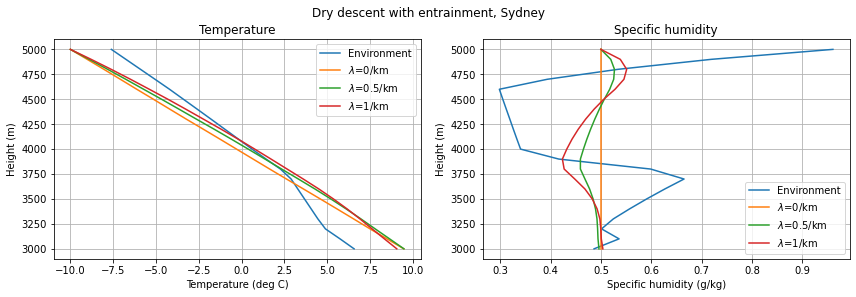

In [25]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(sydney.temperature(height), height, label='Environment')
ax.plot(t1, height, label=r'$\lambda$=0/km')
ax.plot(t2, height, label=r'$\lambda$=0.5/km')
ax.plot(t3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Temperature (deg C)',
    ylabel='Height (m)',
    title='Temperature')

ax = fig.add_subplot(122)
ax.plot(sydney.specific_humidity(height)*1e3, height, label='Environment')
ax.plot(q1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(q2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(q3*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Specific humidity (g/kg)',
    ylabel='Height (m)',
    title='Specific humidity')

fig.tight_layout()
fig.suptitle('Dry descent with entrainment, Sydney', y=1.02)
# fig.savefig(
#     fig_path + 'dry_vs_entrainment_rate.png', dpi=300, facecolor='w',
#     bbox_inches='tight')
plt.show()

- This is in good agreement with the integration method result.
- The higher the entrainment rate, the more strongly the parcel is attracted to the environmental profile and the sooner it reaches equilibrium.

## Moist descent testing

### Moist descent vs. entrainment rate

In [55]:
height = np.arange(5000, 2999, -100)*units.meter
t_initial = -10*units.celsius

q_initial = saturation_specific_humidity(sydney.pressure(height[0]), t_initial)
l_initial = 2e-3

In [56]:
%%time
t1, q1, l1 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 0/units.km)
t2, q2, l2 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 0.5/units.km)
t3, q3, l3 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1/units.km)

CPU times: user 1.43 s, sys: 20.9 ms, total: 1.45 s
Wall time: 1.46 s


The above calculation is about 5 times faster than the one with the integration method!

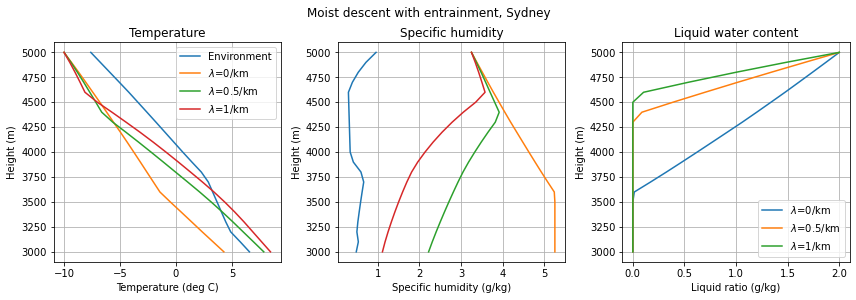

In [62]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.plot(sydney.temperature(height), height, label='Environment')
ax.plot(t1, height, label=r'$\lambda$=0/km')
ax.plot(t2, height, label=r'$\lambda$=0.5/km')
ax.plot(t3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Temperature (deg C)',
    ylabel='Height (m)',
    title='Temperature')

ax = fig.add_subplot(132)
ax.plot(sydney.specific_humidity(height)*1e3, height, label='Environment')
ax.plot(q1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(q2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(q3*1e3, height, label=r'$\lambda$=1/km')
# ax.legend(loc='upper left')
ax.grid()
ax.set(
    xlabel='Specific humidity (g/kg)',
    ylabel='Height (m)',
    title='Specific humidity')

ax = fig.add_subplot(133)
ax.plot(l1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(l2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(l3*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Liquid ratio (g/kg)',
    ylabel='Height (m)',
    title='Liquid water content')

fig.tight_layout()
fig.suptitle('Moist descent with entrainment, Sydney', y=1.03)
# fig.savefig(
#     fig_path + 'moist_vs_entrainment_rate.png', dpi=300, facecolor='w',
#     bbox_inches='tight')
plt.show()

Finally, a result that makes sense!
- The parcel with the highest entrainment rate evaporates its liquid water fastest due to entrainment of subsaturated environmental air. It therefore initially warms the slowest.
- The higher the entrainment rate, the more strongly the parcel's temperature and specific humidity values are attracted to the environmental profile.

## Conclusion

The simple discrete-step descent gives the desired result with better accuracy and higher speed than the integration method.

## Next steps

- Knowing temperature as a function of height, calculate buoyancy and solve equation of motion (relatively simple)
- Reversible adiabats?